In [417]:
import seaborn as sns

import pandas as pd
from IPython.display import display
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.3f}'.format)

import time
import numpy as np
from sklearn.model_selection import KFold, RepeatedKFold, RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, classification_report, f1_score

import matplotlib.pyplot as plt
from catboost import CatBoostRegressor, Pool

import lightgbm as lgb
from lightgbm import Dataset, LGBMRegressor

import xgboost as xgb
from xgboost import XGBRegressor

from sklearn.linear_model import LinearRegression,LassoCV, Ridge, LassoLarsCV,ElasticNetCV
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.tree import DecisionTreeRegressor

import warnings
warnings.filterwarnings('ignore')

In [418]:
train = pd.read_csv("/kaggle/input/data-sets/train.csv")
display(train.head(5))
train.shape

,Id,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Strength
0,230,376.000,0.000,0.000,214.600,0.000,1003.500,762.400,3,16.280
1,231,491.000,26.000,123.000,210.000,3.900,882.000,699.000,56,59.590
2,232,250.000,0.000,95.700,187.400,5.500,956.900,861.200,3,13.820
3,233,310.000,0.000,0.000,192.000,0.000,1012.000,830.000,90,35.760
4,234,252.100,97.100,75.600,193.800,8.300,835.500,821.400,28,33.400


(800, 10)

# EDA

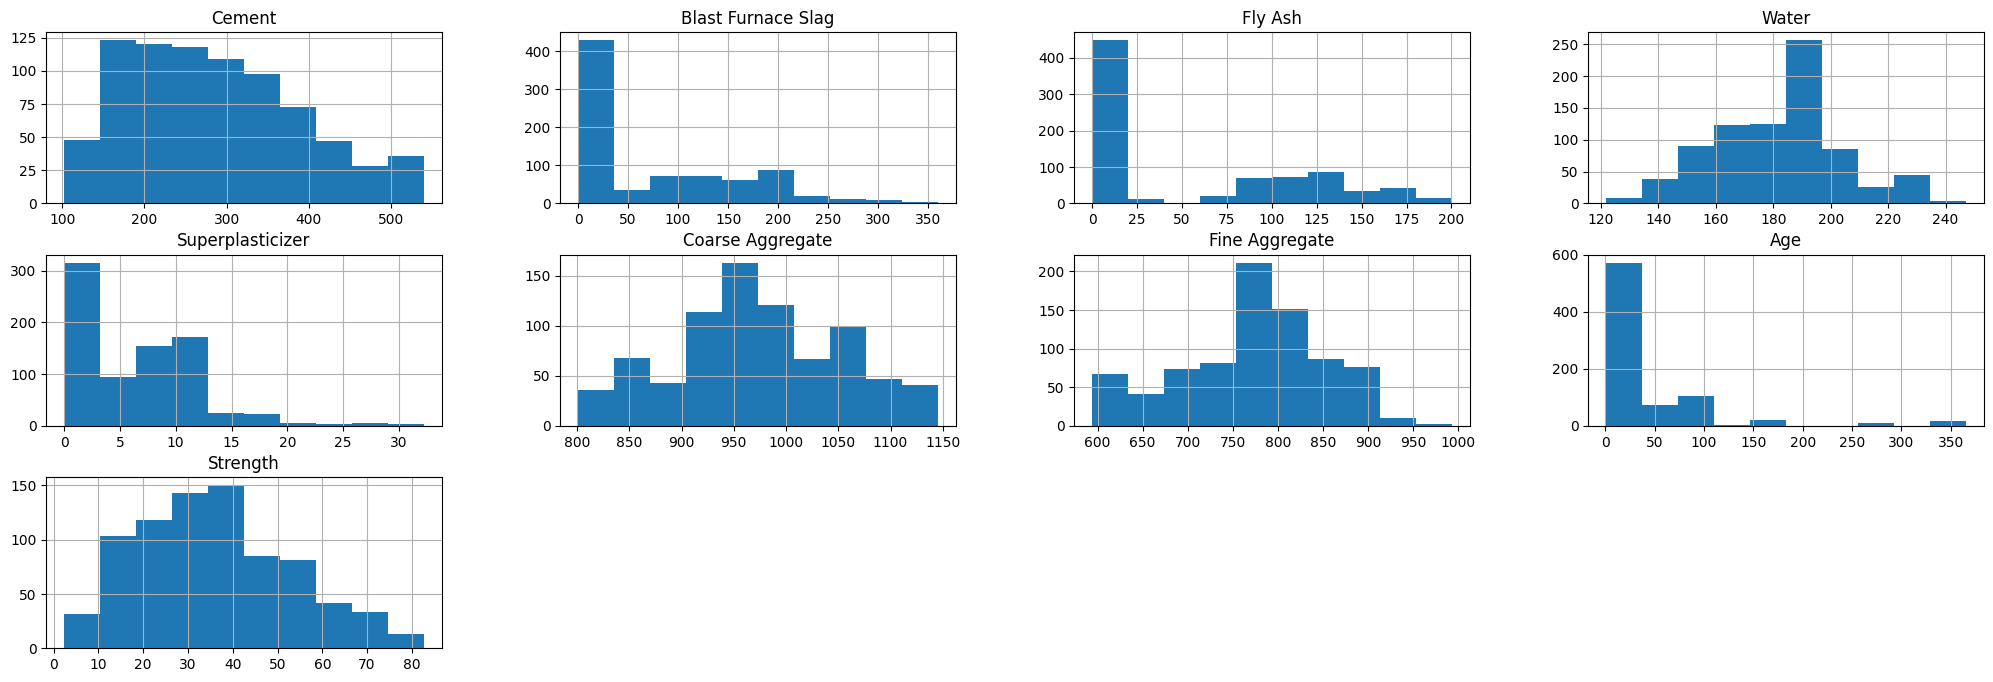

In [419]:
train.drop('Id', axis=1).hist(figsize=(25, 8), layout = (-1, 4));

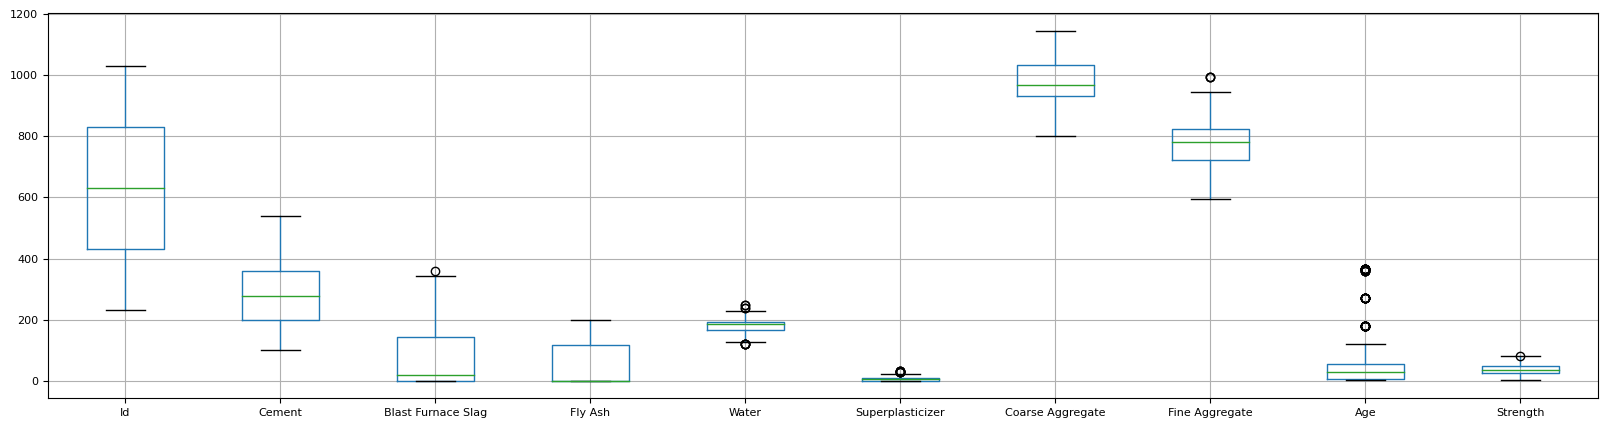

In [420]:
train.boxplot(fontsize=8, figsize=(20, 5));

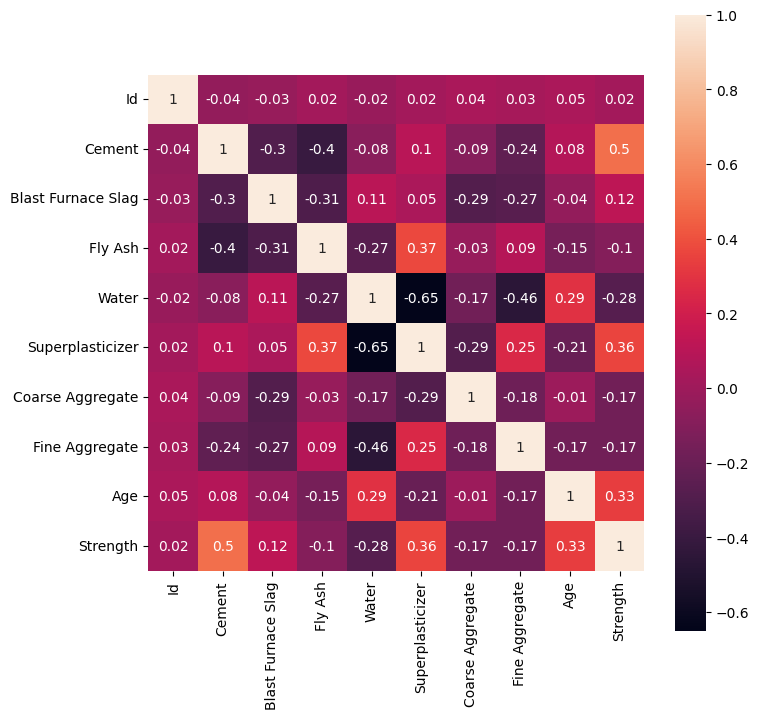

In [421]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(
    data=train.corr(numeric_only=True).round(2),
    square=True,
    annot=True,
);

In [422]:
# train['Superplasticizer_Water'] = train.Superplasticizer - train.Water
# train['Componets'] = train['Coarse Aggregate'] + train['Fine Aggregate']

In [423]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  800 non-null    int64  
 1   Cement              800 non-null    float64
 2   Blast Furnace Slag  800 non-null    float64
 3   Fly Ash             800 non-null    float64
 4   Water               800 non-null    float64
 5   Superplasticizer    800 non-null    float64
 6   Coarse Aggregate    800 non-null    float64
 7   Fine Aggregate      800 non-null    float64
 8   Age                 800 non-null    int64  
 9   Strength            800 non-null    float64
dtypes: float64(8), int64(2)
memory usage: 62.6 KB


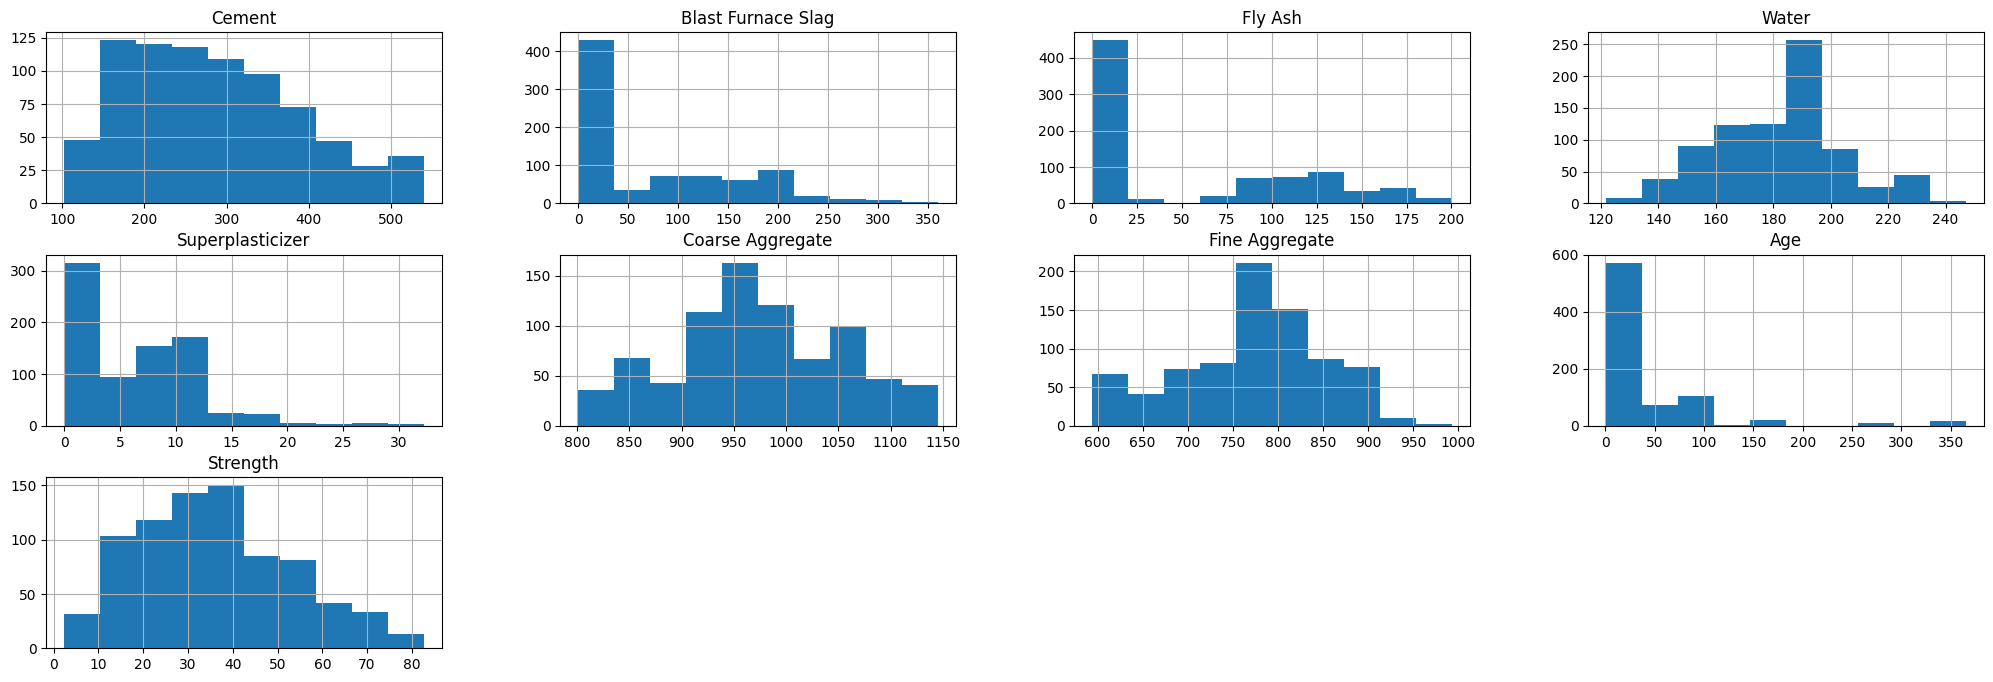

In [424]:
train.drop('Id', axis=1).hist(figsize=(25, 8), layout = (-1, 4));

In [425]:
#checking duplicates
train.duplicated().sum()

0

In [426]:
train.isnull().sum()

Id                    0
Cement                0
Blast Furnace Slag    0
Fly Ash               0
Water                 0
Superplasticizer      0
Coarse Aggregate      0
Fine Aggregate        0
Age                   0
Strength              0
dtype: int64

In [427]:
RANDOM_STATE = 42
results = [] # Здесь будем хранить информацию по каждой модели

In [428]:
def train_model(algorithm,
                X,
                y,
                early_stopping_rounds,
                init_params=None,
                cat_features=None,
                random_seed=2023
    ):
    scores = []
    models = []

    kf = KFold(n_splits=10, shuffle=True, random_state=random_seed)

    print(f"========= TRAINING {algorithm.__name__} =========")

    for num_fold, (train_index, test_index) in enumerate(kf.split(X)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        if init_params is not None:
            model = algorithm(**init_params)
        else:
            model = algorithm()

        if algorithm.__name__ == 'CatBoostRegressor':
            # Используйте соответствующий класс
            train_dataset = Pool(data=X_train, label=y_train, cat_features=cat_features)
            eval_dataset = Pool(data=X_test, label=y_test, cat_features=cat_features)

            model.fit(train_dataset,
                      eval_set=eval_dataset,
                      verbose=0,
                      early_stopping_rounds=early_stopping_rounds)

        elif algorithm.__name__ == 'LGBMRegressor':
            # Используйте соответствующий класс
            train_dataset = Dataset(X_train,y_train,categorical_feature=cat_features,free_raw_data=False)
            eval_dataset = Dataset(X_test,y_test,categorical_feature=cat_features,free_raw_data=False)

            model = lgb.train(params=init_params,
                              train_set=train_dataset,
                              valid_sets=(eval_dataset),
                              categorical_feature=cat_features)

        elif algorithm.__name__ == 'XGBRegressor':
            # Используйте соответствующий класс
            train_matrix = xgb.DMatrix(X_train,label=y_train,nthread=-1,enable_categorical=True)
            eval_matrix = xgb.DMatrix(X_test, y_test,nthread=-1,enable_categorical=True)

            model = xgb.train(params=init_params,
                              dtrain=train_matrix,
                              evals=[(train_matrix, 'dtrain'), (eval_matrix, 'dtest')],
                              verbose_eval=False,
                              early_stopping_rounds=early_stopping_rounds)

            X_test = eval_matrix
        elif algorithm.__name__ == 'GradientBoostingRegressor':
            model = GradientBoostingRegressor(**init_params)
            model.fit(X_train, y_train)

        # Сделайте предсказание на X_eval и посчитайте RMSE
        y_pred = model.predict(X_test)
        score = np.sqrt(mean_squared_error(y_test, y_pred))

        models.append(model)
        scores.append(score)

        print(f'FOLD {num_fold}: SCORE {score}')

    mean_kfold_score = np.mean(scores, dtype="float16") -  np.std(scores, dtype="float16")
    print("\nMEAN RMSE SCORE", mean_kfold_score)

    # Выберите модель с наименьшим значением скора
    best_model_index = np.argmin(score)
    best_model = models[best_model_index]

    return mean_kfold_score, best_model

In [429]:
def tuning_hyperparams(algorithm,
                       X,
                       y,
                       init_params,
                       fit_params,
                       grid_params,
                       n_iter,
                       cv,
                       random_state=2023,
    ):

    estimator = algorithm(**init_params)

    # Можно использоавть GridSearchCV
    model = RandomizedSearchCV(estimator=estimator,
                               param_distributions=grid_params,
                               n_iter=n_iter,
                               cv=cv,
                               scoring='neg_root_mean_squared_error',
                               n_jobs=-1,
                               verbose=0,
                               random_state=random_state
    )

    model.fit(X, y, **fit_params)

    return model.best_params_ | init_params

In [430]:
targets = ["Strength"]
features2drop = ["Id", "Strength"]

# Отбираем итоговый набор признаков для использования моделью
filtered_features = [i for i in train.columns if (i not in targets and i not in features2drop)]

print("targets", targets)

targets ['Strength']


In [431]:
X_train = train[filtered_features].drop(targets, axis=1, errors="ignore")
y_train = train["Strength"]

### CatBoost

In [432]:
cb_init_params = {
    'loss_function': 'RMSE',
    'eval_metric': 'RMSE',
    'thread_count': -1,
    'iterations':3000,
    'random_seed': RANDOM_STATE,
}

cb_score, cb_model = train_model(
    algorithm=CatBoostRegressor,
    X=X_train, y=y_train,
    init_params=cb_init_params,
    early_stopping_rounds=100,
#     cat_features=cat_features,
    random_seed=RANDOM_STATE
)

========= TRAINING CatBoostRegressor =========
FOLD 0: SCORE 4.818336569074412
FOLD 1: SCORE 3.392658515209581
FOLD 2: SCORE 3.672771369958005
FOLD 3: SCORE 3.712282679003705
FOLD 4: SCORE 3.6646277681939448
FOLD 5: SCORE 4.107726480294449
FOLD 6: SCORE 5.19994362702045
FOLD 7: SCORE 4.101722076490484
FOLD 8: SCORE 2.891093804430664
FOLD 9: SCORE 4.294220066100092

MEAN RMSE SCORE 3.344


In [433]:
test = pd.read_csv("/kaggle/input/data-sets/test.csv")
display(test.head(5))
test.shape

,Id,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age
0,0,167.400,129.900,128.600,175.500,7.800,1006.300,746.600,28
1,1,475.000,118.800,0.000,181.100,8.900,852.100,781.500,7
2,2,251.400,0.000,118.300,188.500,6.400,1028.400,757.700,100
3,3,307.000,0.000,0.000,193.000,0.000,968.000,812.000,365
4,4,143.600,0.000,174.900,158.400,17.900,942.700,844.500,28


(230, 9)

In [434]:
X_test = test.drop(features2drop, axis=1, errors="ignore")
cb_pred = cb_model.predict(X_test)

df_submission = pd.DataFrame(data={
    'Id':test['Id'],
    'Catboost':cb_pred}

)



In [435]:
df_submission

,Id,Catboost
0,0,37.910
1,1,49.217
2,2,42.787
3,3,36.114
4,4,18.691
...,...,...
225,225,54.354
226,226,4.715
227,227,38.651
228,228,32.656


In [436]:
lassocv = LassoCV() 
ridge = Ridge() 
lassolarscv = LassoLarsCV()
elasticnetcv = ElasticNetCV()
dtr = DecisionTreeRegressor()

In [437]:
def RMSE(estimator,X_train, y_train, cv=5,n_jobs=-1):
    cv_results = cross_val_score(estimator,X_train,y_train,cv=cv,scoring="neg_mean_squared_error",n_jobs=n_jobs)
    return (np.sqrt(-cv_results)).mean()

In [438]:
RMSE(lassocv, X_train, y_train)

10.515308453878704

In [439]:
RMSE(ridge, X_train, y_train)

10.504501583952674

In [440]:
RMSE(lassolarscv,  X_train, y_train)

10.516490319856981

In [441]:
RMSE(elasticnetcv,  X_train, y_train)

10.514736436827032

In [442]:
RMSE(dtr,  X_train, y_train)

7.188547587137053

In [443]:
RMSE(dtr,  X_train, y_train)

7.3746426257564694

In [444]:
lassocv.fit(X_train, y_train)
ridge.fit(X_train, y_train)
lassolarscv.fit(X_train, y_train)
elasticnetcv.fit(X_train, y_train)
dtr.fit(X_train, y_train)

DecisionTreeRegressor()

In [445]:
# # Gradient Boosting
gb_init_params = { 'n_estimators':3000,
                  'learning_rate':0.05,
                  'max_depth':4, 
                  'max_features':'sqrt',
                  'min_samples_leaf':15, 
                  'min_samples_split':10, 
                  'loss':'huber', 
                  'random_state' :RANDOM_STATE
  }

gb_score, gb_model = train_model(
    algorithm=GradientBoostingRegressor,
    X=X, y=y,
    init_params = gb_init_params,
    early_stopping_rounds=50

)

========= TRAINING GradientBoostingRegressor =========
FOLD 0: SCORE 3.9100278297799553
FOLD 1: SCORE 3.365194759095272
FOLD 2: SCORE 3.5137016722817354
FOLD 3: SCORE 3.5504336088186568
FOLD 4: SCORE 4.741252111792365
FOLD 5: SCORE 3.19273885264032
FOLD 6: SCORE 4.514267223448812
FOLD 7: SCORE 4.517453465189751
FOLD 8: SCORE 3.6476112827299096
FOLD 9: SCORE 4.6954448228199395

MEAN RMSE SCORE 3.4


In [446]:
df_submission['lassocv'] = lassocv.predict(X_test)
df_submission['lassolarscv'] = lassolarscv.predict(X_test)
df_submission['elasticnetcv'] = elasticnetcv.predict(X_test)
df_submission['ridge'] = ridge.predict(X_test)
df_submission['GBoost'] = gb_model.predict(X_test)
df_submission['DecisionTreeRegressor'] = dtr.predict(X_test)


In [447]:
df_submission

,Id,Catboost,lassocv,lassolarscv,elasticnetcv,ridge,GBoost,DecisionTreeRegressor
0,0,37.910,33.838,33.898,33.841,33.898,39.285,41.410
1,1,49.217,53.493,53.497,53.512,53.497,52.538,49.200
2,2,42.787,35.963,36.147,35.941,36.147,42.175,40.150
3,3,36.114,60.941,60.839,60.957,60.839,36.358,33.700
4,4,18.691,28.006,28.236,27.927,28.235,15.723,15.420
...,...,...,...,...,...,...,...,...
225,225,54.354,43.618,43.660,43.616,43.660,54.366,59.300
226,226,4.715,11.776,11.509,11.828,11.509,2.863,2.330
227,227,38.651,50.756,50.758,50.760,50.758,37.433,24.380
228,228,32.656,29.979,29.913,29.989,29.913,32.479,37.260


In [448]:
# final_pred = ((df_submission.CatBoost + df_submission.lassocv + df_submission.lassolarscv + df_submission.elasticnetcv + df_submission.ridge+ df_submission.GBoost + df_submission.DecisionTreeRegressor) / 7)
final_pred = df_submission.iloc[:, 1:8].mean(axis=1)
pd.DataFrame({'Id': test['Id'], 'Strength': final_pred}).to_csv('final_submission.csv', index=False)

pd.DataFrame({'Id': test['Id'], 'Strength': df_submission.Catboost}).to_csv('catboost_submission.csv', index=False)

pd.DataFrame({'Id': test['Id'], 'Strength': df_submission.GBoost}).to_csv('gboost_submission.csv', index=False)

CatGbosts = (df_submission.Catboost + df_submission.GBoost)/ 2
pd.DataFrame({'Id': test['Id'], 'Strength': CatGbosts}).to_csv('CatGbosts_submission.csv', index=False)

0     38.597
1     50.877
2     42.481
3     36.236
4     17.207
       ...  
225   54.360
226    3.789
227   38.042
228   32.567
229    6.457
Length: 230, dtype: float64

In [449]:
# df_submission.to_csv('catboost_submission.csv', index=False)